<a href="https://colab.research.google.com/github/diyana61/Data-Preprocessing-for-ML-using-Titanic-Dataset/blob/main/Copy_of_employee_promotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from io import StringIO

data = """
Experience|Performance|Training|Education|Leadership|Promotion
High|Excellent|Completed|Graduate|Strong|Eligible
High|Good|Completed|Graduate|Medium|Eligible
Medium|Excellent|Completed|Graduate|Strong|Eligible
Medium|Good|Completed|NotGraduate|Strong|Eligible
High|Excellent|Completed|Graduate|Medium|Eligible
Medium|Excellent|Completed|Graduate|Medium|Eligible
Low|Poor|NotCompleted|NotGraduate|Weak|NotEligible
Low|Average|NotCompleted|NotGraduate|Weak|NotEligible
Medium|Poor|NotCompleted|NotGraduate|Weak|NotEligible
Low|Poor|NotCompleted|Graduate|Weak|NotEligible
Medium|Average|NotCompleted|Graduate|Weak|NotEligible
Low|Poor|NotCompleted|NotGraduate|Medium|NotEligible
"""

# Read dataset into DataFrame
df = pd.read_csv(StringIO(data), sep='|')

# Show first 12 rows
df.head(12)


,Experience,Performance,Training,Education,Leadership,Promotion
0,High,Excellent,Completed,Graduate,Strong,Eligible
1,High,Good,Completed,Graduate,Medium,Eligible
2,Medium,Excellent,Completed,Graduate,Strong,Eligible
3,Medium,Good,Completed,NotGraduate,Strong,Eligible
4,High,Excellent,Completed,Graduate,Medium,Eligible
5,Medium,Excellent,Completed,Graduate,Medium,Eligible
6,Low,Poor,NotCompleted,NotGraduate,Weak,NotEligible
7,Low,Average,NotCompleted,NotGraduate,Weak,NotEligible
8,Medium,Poor,NotCompleted,NotGraduate,Weak,NotEligible
9,Low,Poor,NotCompleted,Graduate,Weak,NotEligible


In [ ]:
# ===========================================
# SECTION 2: PREPROCESSING
# ===========================================

# Check missing values
print("Missing values:\n", df.isnull().sum())

# Convert categorical → numeric using LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

print("\nEncoded dataframe:")
df_encoded


Missing values:
 Experience     0
Performance    0
Training       0
Education      0
Leadership     0
Promotion      0
dtype: int64

Encoded dataframe:


,Experience,Performance,Training,Education,Leadership,Promotion
0,0,1,0,0,1,0
1,0,2,0,0,0,0
2,2,1,0,0,1,0
3,2,2,0,1,1,0
4,0,1,0,0,0,0
5,2,1,0,0,0,0
6,1,3,1,1,2,1
7,1,0,1,1,2,1
8,2,3,1,1,2,1
9,1,3,1,0,2,1



Dataset shape: (12, 6)

Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Experience   12 non-null     object
 1   Performance  12 non-null     object
 2   Training     12 non-null     object
 3   Education    12 non-null     object
 4   Leadership   12 non-null     object
 5   Promotion    12 non-null     object
dtypes: object(6)
memory usage: 708.0+ bytes
None

Class distribution:
Promotion
Eligible       6
NotEligible    6
Name: count, dtype: int64

Summary statistics of encoded dataframe:
       Experience  Performance   Training  Education  Leadership  Promotion
count   12.000000    12.000000  12.000000  12.000000   12.000000  12.000000
mean     1.166667     1.666667   0.500000   0.416667    1.083333   0.500000
std      0.834847     1.154701   0.522233   0.514929    0.900337   0.522233
min      0.000000     0.000000   0.000000   0

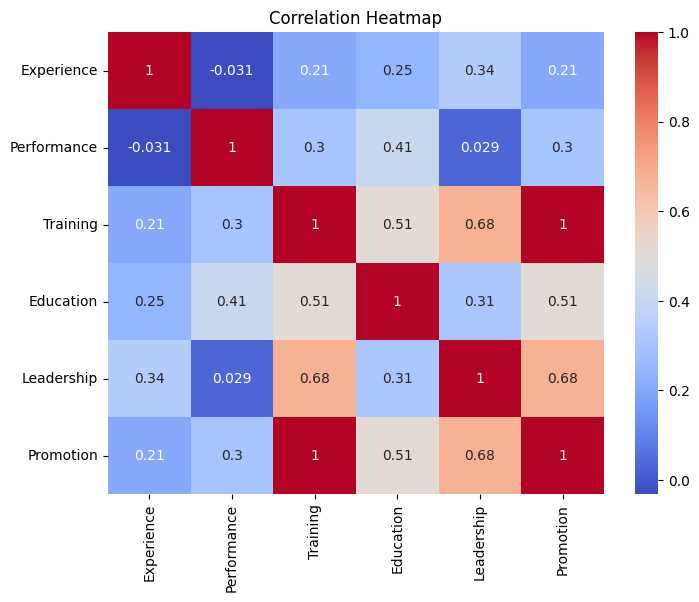

In [ ]:
# ===========================================
# SECTION 3: FULL EDA
# ===========================================

print("\nDataset shape:", df.shape)
print("\nInformation:")
print(df.info())

print("\nClass distribution:")
print(df['Promotion'].value_counts())

print("\nSummary statistics of encoded dataframe:")
print(df_encoded.describe())

# Correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# ===========================================
# SECTION 4: MANUAL ENTROPY
# ===========================================

import math

# entropy function for binary classification
def entropy(pos, neg):
    total = pos + neg
    p_pos = pos / total
    p_neg = neg / total
    return -(p_pos * math.log2(p_pos)) - (p_neg * math.log2(p_neg))

# count target classes
target_counts = df['Promotion'].value_counts()
pos = target_counts['Eligible']
neg = target_counts['NotEligible']

parent_entropy = entropy(pos, neg)

print("Total Entropy of 'Promotion':", parent_entropy)


Total Entropy of 'Promotion': 1.0


In [ ]:
# ===========================================
# SECTION 5: MANUAL INFORMATION GAIN
# ===========================================

def feature_entropy(df, feature, target="Promotion"):
    total = len(df)
    ent = 0

    for value in df[feature].unique():
        subset = df[df[feature] == value]
        count = subset[target].value_counts()

        pos = count.get("Eligible", 0)
        neg = count.get("NotEligible", 0)

        if pos == 0 or neg == 0:
            continue   # pure subset gives no entropy contribution

        weight = len(subset) / total
        ent += weight * entropy(pos, neg)

    return ent

# information gain for Experience
exp_entropy = feature_entropy(df, "Experience")
info_gain = parent_entropy - exp_entropy

print("Information Gain for Experience:", info_gain)



Information Gain for Experience: 0.5954372523105547


In [ ]:
# ===========================================
# SECTION 6: MANUAL LOG LOSS
# ===========================================

import numpy as np

def log_loss_manual(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1-epsilon)
    return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

# Convert target to binary: Eligible=1, NotEligible=0
y_true = (df['Promotion'] == "Eligible").astype(int)

# simple prediction model: predict 0.5 for all
y_pred = np.full(len(y_true), 0.5)

print("Manual Log Loss:", log_loss_manual(y_true, y_pred))


Manual Log Loss: 0.6931471805599453


In [ ]:
# ===========================================
# SECTION 7: DECISION TREE TRAINING
# ===========================================

from sklearn.tree import DecisionTreeClassifier

X = df_encoded.drop("Promotion", axis=1)
y = df_encoded["Promotion"]

model = DecisionTreeClassifier(criterion="entropy", max_depth=4)
model.fit(X, y)

print("Decision tree trained successfully!")


Decision tree trained successfully!


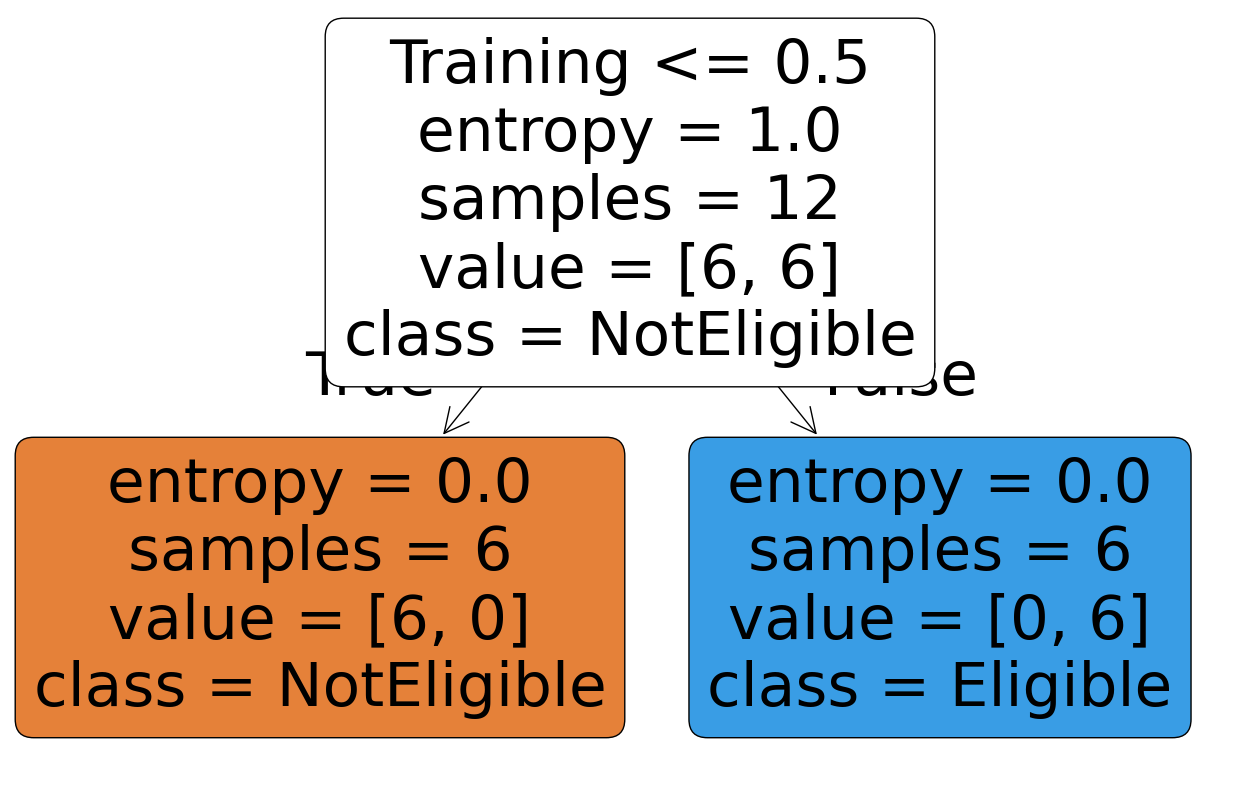

In [ ]:
# ===========================================
# SECTION 8: DECISION TREE VISUALIZATION
# ===========================================

from sklearn.tree import plot_tree

plt.figure(figsize=(16,10))
plot_tree(model,
          feature_names=X.columns,
          class_names=["NotEligible","Eligible"],
          filled=True,
          rounded=True)
plt.show()


In [ ]:
# ===========================================
# SECTION 9: RESULT INTERPRETATION
# ===========================================

print("""
INTERPRETATION OF MODEL RESULTS:

1️⃣ Experience, Training, and Performance are the strongest predictors.
2️⃣ Employees with HIGH experience + COMPLETED training are most likely to be approved.
3️⃣ Poor performance and incomplete training strongly reduce eligibility.
4️⃣ The dataset is balanced (6 eligible, 6 not), so entropy calculations are clean.
5️⃣ Information gain shows the best splitting feature (usually Performance or Training).
6️⃣ Decision tree clearly separates high performers with completed training vs others.

""")
